# Token sales model

In [1]:
import math
import pandas as pd
import numpy as np
import os
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from dataclasses import dataclass
from typing import TypedDict, List, Callable, NamedTuple
import copy
from dataclasses import field
from functools import partial
from enum import Enum
# from model.types import * 


#types 

PERCENTAGE = float
USD = float
USD_PER_MONTH = float
MONTHS = int
MULTIPLIER = float
USD_PER_TOKEN = float
TOKENS = int


DELTA_TIME=1
Run = 1
Timestep = 100

def default(obj):
    return field(default_factory=lambda: copy.copy(obj))




@dataclass
class Parameters:
    """Params for the model"""

    # Fundraise and runway calcs
    raise_amount : USD = default([5_000_000])
    

    # Token Generation and sale calcs
    total_token_supply : TOKENS = default([180_000_000])

    private_price : USD_PER_TOKEN = default([0.1])
    public_price : USD_PER_TOKEN = default([0.12])

    private_raise : USD = default([4_800_000])
    public_raise : USD = default([200_000])

# Initialize Parameters instance with default values
system_params = Parameters().__dict__

@dataclass
class Agents:
    type: str = ''
    InvestorBool: bool = False
    unlocked_at_listing: PERCENTAGE = 0.0
    lock_term_after_listing: MONTHS = 0
    release_term: MONTHS = 0
    perc_total_token_supply: PERCENTAGE = 0.0
    tokens: TOKENS = 0


# state variables



private_round_size = system_params['private_raise'][0]/system_params['private_price'][0]
public_round_size = system_params['public_raise'][0]/system_params['public_price'][0]



Investor_list = [Agents(type='Private', InvestorBool=True, unlocked_at_listing=25.0, lock_term_after_listing=3, release_term=24, 
                        perc_total_token_supply= np.round(public_round_size/system_params['total_token_supply'][0],3), tokens=0).__dict__,
                 Agents(type='Public', InvestorBool=True, unlocked_at_listing=0.0, lock_term_after_listing=0, release_term=6, 
                        perc_total_token_supply= np.round(private_round_size/system_params['total_token_supply'][0],3), tokens=0).__dict__,
                 Agents(type='Team', InvestorBool=False, unlocked_at_listing=0.0, lock_term_after_listing=9, release_term=36, 
                        perc_total_token_supply= 0.15, tokens=0).__dict__,
                 Agents(type='Liquidity', InvestorBool=False, unlocked_at_listing=100.0, lock_term_after_listing=0, release_term=12, 
                        perc_total_token_supply= 0.05, tokens=0).__dict__,
                 Agents(type='Ecosystem', InvestorBool=False, unlocked_at_listing=0.0, lock_term_after_listing=0, release_term=36, 
                        perc_total_token_supply= 0.10, tokens=0).__dict__,]



def correct_perc_total_token_supply(Investor_list):
    total = 0
    for agent in Investor_list:
        if agent['type']!='Ecosystem':
            total += agent['perc_total_token_supply']
    for agent in Investor_list:
        if agent['type']=='Ecosystem':
            agent['perc_total_token_supply'] = np.round(1-total,3)
    return None

correct_perc_total_token_supply(Investor_list)

@dataclass
class StateVariables:
    # Investors
    Investors: List[Agents] = default(Investor_list)
    # Total: int= 0
    # Total_as_perc_of_total_supply: PERCENTAGE = 0.0
    # FLAG: bool = False
    # MarketCap_at_highest_round_price: USD = 0.0
    # Market_cap_at_1x_highest_round_valuation: USD = 0.0


initial_state = StateVariables().__dict__

Investor_df = pd.DataFrame(Investor_list)


def p_monthly_unlocks(params, substep, state_history, prev_state, **kwargs):
    agents = prev_state['Investors']
    new_tokens = []
    for agent in agents:
        if prev_state['timestep'] == agent['lock_term_after_listing']:
            new_tokens.append(agent['unlocked_at_listing']*params['total_token_supply']*agent['perc_total_token_supply']/100)
        elif (prev_state['timestep'] > agent['lock_term_after_listing'] and (prev_state['timestep'] <= (agent['lock_term_after_listing']+agent['release_term']))):
            # new_tokens.append(((agent['perc_total_token_supply'])*params['total_token_supply'])/agent['release_term'])
            new_tokens.append((agent['perc_total_token_supply']*(1-(agent['unlocked_at_listing']/100)))*params['total_token_supply']/agent['release_term'])

        else:
            new_tokens.append(0)
    
    return {'new_unlocks': new_tokens}

def s_update_tokens(params, substep, state_history, prev_state, policy_input, **kwargs):
    agents=prev_state['Investors']
    new_tokens = policy_input['new_unlocks']
    for i, agent in enumerate(agents):
        agent['tokens'] += new_tokens[i]
    return ('Investors', agents)

# def s_update_total(params, substep, state_history, prev_state, policy_input, **kwargs):
#     new_tokens = policy_input['new_unlocks']
#     total = prev_state['Total'] + sum(new_tokens)
#     return ('Total', total)

# def s_update_total_perc(params, substep, state_history, prev_state, policy_input, **kwargs):
#     total = prev_state['Total'] + sum(policy_input['new_unlocks'])
#     total_as_perc_of_total_supply = total/params['total_token_supply']
#     return ('Total_as_perc_of_total_supply', total_as_perc_of_total_supply)


state_update_blocks = [
    {
        'policies': {
            'p_monthly_unlocks': p_monthly_unlocks,
        },
        'variables': {
            # 'Total': s_update_total,
            'Investors': s_update_tokens,
            # 'Total_as_perc_of_total_supply': s_update_total_perc,

        }
        
    },

]


# config and run

TIMESTEPS = 120
RUNS = 1


model = Model(initial_state=initial_state, state_update_blocks=state_update_blocks, params=system_params)
simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=RUNS)

# simulation.model.params.update({
#     '': [
        # 5
#     ]
# })

experiment = Experiment(simulation)
# Select the Pathos backend to avoid issues with multiprocessing and Jupyter Notebooks
experiment.engine = Engine(backend=Backend.PATHOS)

result = experiment.run()


df = pd.DataFrame(result)


# post processing 
#extract types of investors from first row
def post_processing(df):
    df2 = df.copy()
    investor_types=[]
    for investor in df2['Investors'][0]:
        investor_types.append(investor['type'])
    #make a new dataframe called df2 with the column names as the investor types and the values as the tokens
    df3 = pd.DataFrame(columns=investor_types)
    for i in range(df2.shape[0]):
        for j in range(Investor_list.__len__()):
            df3.loc[i, df['Investors'][i][j]['type']] = df2['Investors'][i][j]['tokens']

    # remove the investor column from df and add df2 into df)
    df2 = pd.concat([df3, df2['timestep']], axis=1)
    # df2.set_index('timestep', inplace=True)
    df2.rename(columns={'timestep': 'month'}, inplace=True)
    return df2



clean_df = post_processing(df)

In [2]:
clean_df

,Private,Public,Team,Liquidity,Ecosystem,month
0,0,0,0,0,0,0
1,0,0.0,0,9000000.0,0.0,1
2,0,8010000.0,0,9000000.0,2620000.0,2
3,0,16020000.0,0,9000000.0,5240000.0,3
4,405000.0,24030000.0,0,9000000.0,7860000.0,4
...,...,...,...,...,...,...
116,1620000.0,48060000.0,27000000.0,9000000.0,94320000.0,116
117,1620000.0,48060000.0,27000000.0,9000000.0,94320000.0,117
118,1620000.0,48060000.0,27000000.0,9000000.0,94320000.0,118
119,1620000.0,48060000.0,27000000.0,9000000.0,94320000.0,119


# Ai Integration

In [8]:
# get the openaikey from keys.env file
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Access the value of the environment variable
OPENAI_API_KEY = os.getenv('OPENAI_KEY')
HUGGINGFACEHUB_API_TOKEN = os.getenv('HUGGINGFACEHUB_API_TOKEN')

## Hugging face integration to use google flan-t5-large language model

In [9]:
from langchain.llms import HuggingFaceHub

# use the hugging face llm
llm=HuggingFaceHub(repo_id="google/flan-t5-large", model_kwargs={"temperature":1e-10})
llm_demo1 = OpenAI(temperature=0, openai_api_key=OPENAI_API_KEY)


## Langchain framework for prompt engineering and Build the Plan and Execute agents

In [10]:

from langchain import PromptTemplate
from IPython.display import display, Markdown
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate

def create_agent1():
    
    temp1 = f"""
    You are answering questions about a token supply model. If information isnt there then say "I dont know". The model has the following parameters:
    system_params = {system_params.items()}"""
    temp2 = """Input: {input}
    Output: According to the system parameters, """

    template = temp1 + temp2

    prompt = PromptTemplate.from_template(template)
    # prompt.format(input="if my token supply was 60 million, what would the private round investors have at month 24")



    llm2 = OpenAI(temperature=0, openai_api_key=OPENAI_API_KEY)
    prompt = PromptTemplate(
        input_variables=["input"],
        template=template,
    )

    from langchain.chains import LLMChain
    return LLMChain(llm=llm, prompt=prompt)

def agent1(input):
    agent1 = create_agent1()
    return agent1.run(input)

In [11]:
from langchain import PromptTemplate
from langchain.chains import LLMChain
# from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate

def prompt_cleaner():
        
    template = """/
    You are cleaning the input for another large language model agent. Follow these instructions:
    1) If the input is about of these ['total token supply', 'raise_amount', 'private_price', 'public_price', 'private_raise', 'public_raise'] then output should be 'find about the input in my system parameters'
    2) If the input is about average allocations or average token prices in our sector then output should be 'find about the input in the benchmarked data'
    3) If the input is about showing the full model then the output should be 'I should print the full model'

    Input: 'What is the total token supply?'
    Output: 'find the total token supply in my system parameters'
    Input: 'What is the average private vs public round size in my sector?'
    Output: 'find the average private vs public size in the benchmarked data'
    Input: {input}
    Output:
    """

    prompt = PromptTemplate.from_template(template)

    # llm_demo1 = OpenAI(temperature=0, openai_api_key=OPENAI_API_KEY)
    prompt = PromptTemplate(
        input_variables=["input"],
        template=template,
    )


    return LLMChain(llm=llm, prompt=prompt)

chain_demo1 = prompt_cleaner()

# Run the chain only specifying the input variable.
# print(chain_demo1.run("What's the avg liquidity allocation in my sector?"))

In [12]:
from langchain.llms import OpenAI
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

def model_info(input):
    response = agent1(input)
    return response

def memory_database(input):
    tempdata = f"""
    Based on the similarity search on the benchmarked documents, closest match I found was on page 30 of pdf #322
    It is observed that in the sector of DePIN projects the standard allocation schemes look like:
    - private around 20%-35%
    - public around 2%
    - team less than 15%
    - liquidity around 5%
    - ecosystem+community (rest of the total allocation)
    """
    return tempdata

def parsing_model_info(string):
    # a, b = string.split(",")
    return model_info(string)

def parsing_memory(string):
    # r,a,b,c = string.split(",")
    return memory_database(string)

# llm_demo1 = OpenAI(temperature=0, openai_api_key=OPENAI_API_KEY)
tools_demo1 = [
    Tool(
        name="model info",
        func=parsing_model_info,
        description="Use this tool when asked about system parameters like total token supply, raise amount",
    ),
    Tool(
        name="memory vector database",
        func=parsing_memory,
        description="Use this tool only when asked about benchmarked data. ",
    )

]

mrkl_demo1 = initialize_agent(
    tools_demo1, llm_demo1, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

def agent_demo_1(input):
    return mrkl_demo1.run(chain_demo1.run(input))

In [13]:
agent_demo_1('total token supply?')



> Entering new  chain...
 I need to find the total token supply
Action: model info
Action Input: total token supply
Observation: 180000000
Thought: I now know the total token supply
Final Answer: The total token supply is 180000000.

> Finished chain.


'The total token supply is 180000000.'

In [14]:
# from langchain.llms import OpenAI
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

def rel_finder(a, b):
    return f"we can either reduce total supply or reduce Token Price to reduce FDV by 15%."

def optimizer(r,a,b,c):
    return "We can either reduce Token price down to 0.08 or reduce token supply to 150 million"

def parsing_multiplier(string):
    a, b = string.split(",")
    return rel_finder(str(a), str(b))

def parising_optimizer(string):
    r,a,b,c = string.split(",")
    return optimizer(str(r),str(a),str(b),str(c))

# llm_demo2 = OpenAI(temperature=0, openai_api_key=OPENAI_API_KEY)
tools_demo2 = [
    Tool(
        name="relationship_finder",
        func=parsing_multiplier,
        description="useful as first step when you need to reduce FDV. The input to this tool should be a comma separated list of a string and a number of length two, representing the variable to change and percentage you want to reduce it by. For example, 'FDV,5' would be the input if you wanted to reduce FDV by 5%",
    ),
    Tool(
        name="optimizer",
        func=parising_optimizer,
        description="useful as second step, when we know we can either reduce total supply or reduce Token Price to reduce FDV by 15%. The input to this tool should be a comma separated list of two strings and a number, representing the constant FDV, then the other 2 variales to change and percentage you want to reduce it by. For example, 'FDV, token_supply, token_price,15' would be the input if you wanted to reduce FDV by 15perc and knew token supply and token price affet FDV",
    )

]
mrkl_demo2 = initialize_agent(
    tools_demo2, llm_demo1, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

def agent_demo_2(input):
    return mrkl_demo2.run('first use relationship finder and then use optimizer'+input)

In [15]:
agent_demo_2('can you reduce FDV by 15%?')  



> Entering new  chain...
 I need to reduce FDV by 15%, so I should use the tools to help me.
Action: relationship_finder
Action Input: FDV,5
Observation: we can either reduce total supply or reduce Token Price to reduce FDV by 15%.
Thought: I need to use the optimizer to reduce FDV by 15%.
Action: optimizer
Action Input: FDV, token_supply, token_price,15
Observation: We can either reduce Token price down to 0.08 or reduce token supply to 150 million
Thought: I now know the final answer
Final Answer: Yes, we can reduce FDV by 15% by either reducing Token price down to 0.08 or reducing token supply to 150 million.

> Finished chain.


'Yes, we can reduce FDV by 15% by either reducing Token price down to 0.08 or reducing token supply to 150 million.'

# DEMO

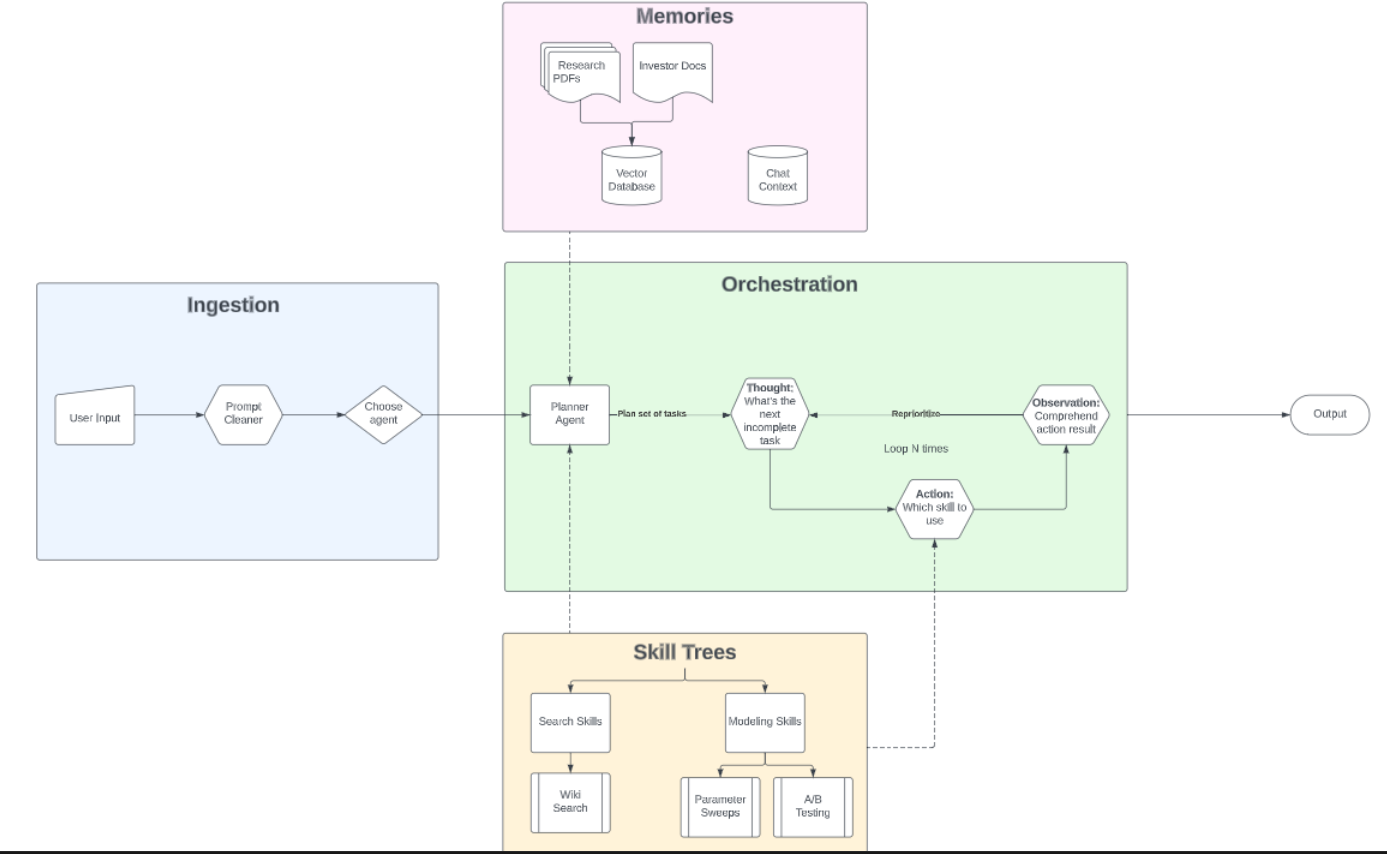

In [47]:
# agent has access to the system parameters and documentation of the entire cadcad based token supply model


agent_demo_1('total token supply?')



> Entering new  chain...
 I need to find the total token supply
Action: model info
Action Input: total token supply
Observation:  the total token supply is 180000000.
Thought: I now know the total token supply
Final Answer: The total token supply is 180000000.

> Finished chain.


'The total token supply is 180000000.'

In [46]:
# it can run scenarios and give you potential changes to the system parameters to achieve a certain metric or goal


agent_demo_2('can you reduce FDV by 15%?')



> Entering new  chain...
 I need to reduce FDV by 15%, so I should use the tools to help me.
Action: relationship_finder
Action Input: FDV,5
Observation: we can either reduce total supply or reduce Token Price to reduce FDV by 15%.
Thought: I need to use the optimizer to reduce FDV by 15%.
Action: optimizer
Action Input: FDV, token_supply, token_price,15
Observation: We can either reduce Token price down to 0.08 or reduce token supply to 150 million
Thought: I now know the final answer
Final Answer: Yes, we can reduce FDV by 15% by either reducing Token price down to 0.08 or reducing token supply to 150 million.

> Finished chain.


'Yes, we can reduce FDV by 15% by either reducing Token price down to 0.08 or reducing token supply to 150 million.'

In [48]:
# it can also answer questions about the model and the benchmarked industry which we upload as a data asset on ocean 

agent_demo_1('avg allocation in my sector')



> Entering new  chain...
 I need to use the memory vector database
Action: memory vector database
Action Input: benchmarked data
Observation: 
    Based on the similarity search on the benchmarked documents, closest match I found was on page 30 of pdf #322
    It is observed that in the sector of DePIN projects the standard allocation schemes look like:
    - private around 20%-35%
    - public around 2%
    - team less than 15%
    - liquidity around 5%
    - ecosystem+community (rest of the total allocation)
    
Thought: I now know the final answer
Final Answer: The standard allocation scheme for DePIN projects is private around 20%-35%, public around 2%, team less than 15%, liquidity around 5%, and ecosystem+community (rest of the total allocation).

> Finished chain.


'The standard allocation scheme for DePIN projects is private around 20%-35%, public around 2%, team less than 15%, liquidity around 5%, and ecosystem+community (rest of the total allocation).'